In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-06-28 22:33:49.410107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-06-28 22:33:56.310646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 22:33:56.320019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 22:33:56.321061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [4]:
# Build the model
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, dropout = 0.1):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [5]:
# Compile the model
def compile_model(classifier_model, train_ds, lr = 3e-6, epochs = 5):
    # model fine tuning
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=metrics)
    return classifier_model

In [6]:
# Prepare dataset
def prepare_data(dataset):
    # Load the dataset
    df = pd.read_csv(f'../dataset/{dataset}', encoding='utf-8').dropna()
    df.columns = ['label', 'text']
    
    # Sample only 20% to test BERT training faster
    df, df_discard = train_test_split(df, test_size=0.8, random_state=7)

    # Use sklearn to split the dataset into training, validating and testing
    train_df, val_df = train_test_split(df, test_size=0.7, random_state=7)
    val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=7)

    # Create training dataset
    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = 32

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values)
    )
    train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df['text'].values, val_df['label'].values)
    )
    val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create testing dataset
    test_ds = tf.data.Dataset.from_tensor_slices(
        (test_df['text'].values, test_df['label'].values)
    )
    test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds


In [7]:
# Show result
def evaluate_model(classifier_model, test_ds):
    # Evaluate performance
    loss, accuracy = classifier_model.evaluate(test_ds)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    
def show_history(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

Performance for learning rate:  3e-05
Epoch 1/10
62/62 [==============================] - 24s 280ms/step - loss: 0.4087 - binary_accuracy: 0.8002 - val_loss: 0.2034 - val_binary_accuracy: 0.9158
Epoch 2/10
62/62 [==============================] - 16s 265ms/step - loss: 0.2251 - binary_accuracy: 0.9051 - val_loss: 0.1667 - val_binary_accuracy: 0.9345
Epoch 3/10
62/62 [==============================] - 16s 268ms/step - loss: 0.1654 - binary_accuracy: 0.9354 - val_loss: 0.1677 - val_binary_accuracy: 0.9355
Epoch 4/10
62/62 [==============================] - 16s 268ms/step - loss: 0.1488 - binary_accuracy: 0.9420 - val_loss: 0.1558 - val_binary_accuracy: 0.9409
Epoch 5/10
62/62 [==============================] - 17s 269ms/step - loss: 0.1287 - binary_accuracy: 0.9475 - val_loss: 0.1757 - val_binary_accuracy: 0.9393
Epoch 6/10
62/62 [==============================] - 17s 270ms/step - loss: 0.1342 - binary_accuracy: 0.9516 - val_loss: 0.1757 - val_binary_accuracy: 0.9393
Epoch 7/10
62/62 [==

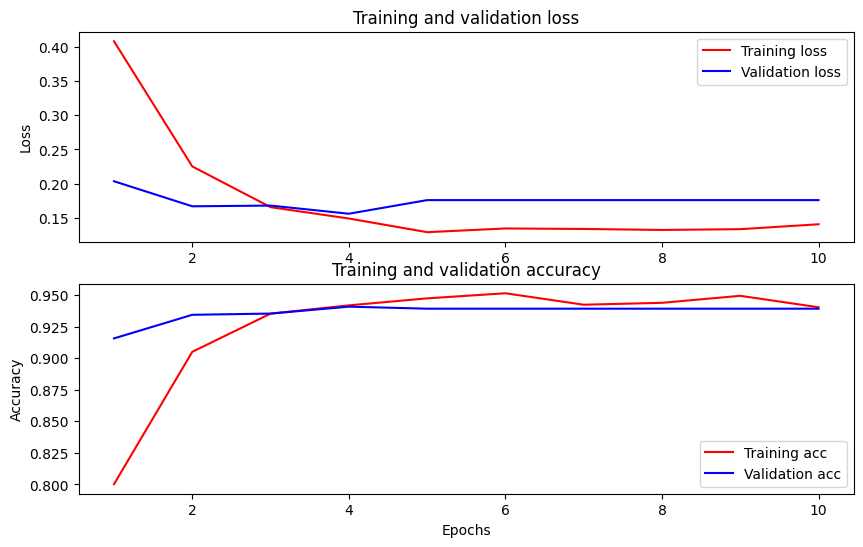

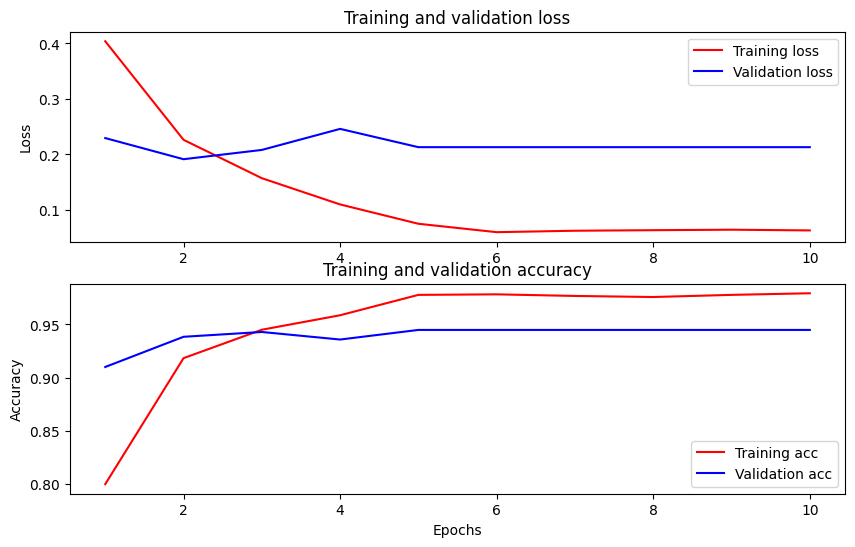

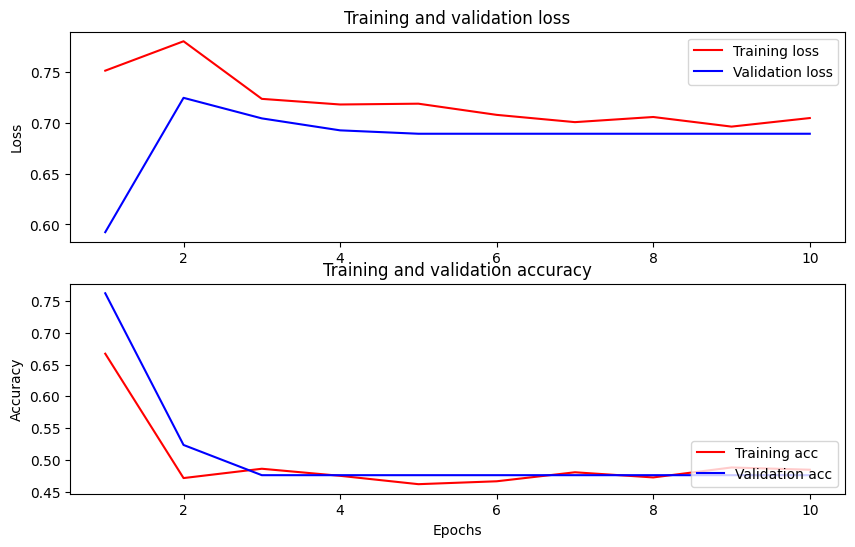

In [11]:
# Try performance on different dataset

# Define list of dropout
learningRates = [3e-5, 3e-4, 3e-3]

for lr in learningRates:
    print("Performance for learning rate: ", lr)
    model = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess)
    train_ds, val_ds, test_ds = prepare_data('best_dataset.csv')
    classifier_model = compile_model(model, train_ds, lr)
    history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=10)
    evaluate_model(classifier_model, test_ds)
    show_history(history)

In [ ]:
# Save the model
classifier_model.save('saved_model/bertSmsClassifier')

In [25]:
#Try loading
from keras.models import load_model

loaded_model = load_model('saved_model/bertSmsClassifier', compile=False)

In [ ]:
# Plot confusion matrix and graph
def plot_confusion_matrix(y, y_pred, type, target_names = ['Ham', 'Spam']):
    print('Confusion matrix - ' + type)
    print(classification_report(y, y_pred, target_names=target_names))

    # Plot the confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - ' + type)
    plt.show()

In [ ]:
# Evaluate performance in term of confusing matrix
# Check confusion matrix given dataset and model. Reference: https://colab.research.google.com/drive/1kEg0SnYNtw_IJwu_kl5y3qRVs-BKBmNO#scrollTo=_r4smPUZymS5
def evaluateDatasetConfusionMatrix(dataset, model):
    train_ds, val_ds, test_ds = prepare_data('best_dataset.csv')

    y_val_pred = tf.math.argmax(tf.nn.softmax(model.predict(val_ds)), axis=1)
    y_test_pred = tf.math.argmax(tf.nn.softmax(model.predict(test_ds)), axis=1)

    y_val = tf.Variable([], dtype=tf.int64)
    for features, label in val_ds.take(-1):
        y_val = tf.concat([y_val, label], 0)

    y_test = tf.Variable([], dtype=tf.int64)
    for features, label in test_ds.take(-1):
        y_test = tf.concat([y_test, label], 0)

    plot_confusion_matrix(y_val, y_val_pred, 'Validation')
    plot_confusion_matrix(y_test, y_test_pred, 'Testing')

In [26]:
result = loaded_model.predict([["付款 成功 公眾 號 發出 付款 成功 的 消息 加上 自定義 連結 付款 成功 後 公眾 號 發出 付款 成功 的 消息 可以 加上 自定義 連結 嗎"]])
print(result)

1/1 [==============================] - 0s 454ms/step
[[6.785988]]
